## Layer-wise NN
In practice it is common to feed multiple data into NN. Therefore below it's a implementation of *layer-wise* network. By doing so, we fully ultilizes the parallel computing power of GPU. 

BP, diagram explained:
![](https://d17h27t6h515a5.cloudfront.net/topher/2016/December/5841c067_miniflow-nn-graph.001/miniflow-nn-graph.001.jpeg)

The code below implements the BP diagram. The only confusing part is that at the very end of the "cost" function, there shouldn't be another arrow going out. Also there are some notational difference regarding the "activation" symbol in the "MSE" layer. Notice it uses $a$ instead of $I$. Other than that, they are pretty much the same.

In [27]:
import numpy as np

class Layer:
    """
    Base class for layers in the network.

    Arguments:

        `inbound_layers`: A list of layers with edges into this layer.
    """
    def __init__(self, inbound_layers=[]):
        """
        Layer's constructor (runs when the object is instantiated). Sets
        properties that all layers need.
        """
        # A list of layers with edges into this layer.
        self.inbound_layers = inbound_layers
        # The eventual value of this layer. Set by running
        # the forward() method.
        self.value = None
        # A list of layers that this layer outputs to.
        self.outbound_layers = []
        # New property! Keys are the inputs to this layer and
        # their values are the partials of this layer with
        # respect to that input.
        self.gradients = {}
        # Sets this layer as an outbound layer for all of
        # this layer's inputs.
        for layer in inbound_layers:
            layer.outbound_layers.append(self)

    def forward():
        """
        Every layer that uses this class as a base class will
        need to define its own `forward` method.
        """
        raise NotImplementedError

    def backward():
        """
        Every layer that uses this class as a base class will
        need to define its own `backward` method.
        """
        raise NotImplementedError


class Input(Layer):
    """
    A generic input into the network.
    """
    def __init__(self):
        # The base class constructor has to run to set all
        # the properties here.
        #
        # The most important property on an Input is value.
        # self.value is set during `topological_sort` later.
        Layer.__init__(self)

    def forward(self):
        # Do nothing because nothing is calculated.
        pass

    def backward(self):
        # An Input layer has no inputs so the gradient (derivative)
        # is zero.
        # The key, `self`, is reference to this object.
        self.gradients = {self: 0}
        # Weights and bias may be inputs, so you need to sum
        # the gradient from output gradients.
        for n in self.outbound_layers:
            grad_cost = n.gradients[self]
            self.gradients[self] += grad_cost * 1


class Linear(Layer):
    """
    Represents a layer that performs a linear transform.
    """
    def __init__(self, X, W, b):
        # The base class (Layer) constructor. Weights and bias
        # are treated like inbound layers.
        Layer.__init__(self, [X, W, b])

    def forward(self):
        """
        Performs the math behind a linear transform.
        """
        X = self.inbound_layers[0].value
        W = self.inbound_layers[1].value
        b = self.inbound_layers[2].value
        self.value = np.dot(X, W) + b

    def backward(self):
        """
        Calculates the gradient based on the output values.
        """
        # Initialize a partial for each of the inbound_layers.
        self.gradients = {n: np.zeros_like(n.value) for n in self.inbound_layers}
        # Cycle through the outputs. The gradient will change depending
        # on each output, so the gradients are summed over all outputs.
        for n in self.outbound_layers:
            # Get the partial of the cost with respect to this layer.
            grad_cost = n.gradients[self]
            # Set the partial of the loss with respect to this layer's inputs.
            self.gradients[self.inbound_layers[0]] += np.dot(grad_cost, self.inbound_layers[1].value.T)
            # Set the partial of the loss with respect to this layer's weights.
            self.gradients[self.inbound_layers[1]] += np.dot(self.inbound_layers[0].value.T, grad_cost)
            # Set the partial of the loss with respect to this layer's bias.
            self.gradients[self.inbound_layers[2]] += np.sum(grad_cost, axis=0, keepdims=False)


class Sigmoid(Layer):
    """
    Represents a layer that performs the sigmoid activation function.
    """
    def __init__(self, layer):
        # The base class constructor.
        Layer.__init__(self, [layer])

    def _sigmoid(self, x):
        """
        This method is separate from `forward` because it
        will be used with `backward` as well.

        `x`: A numpy array-like object.
        """
        return 1. / (1. + np.exp(-x))

    def forward(self):
        """
        Perform the sigmoid function and set the value.
        """
        input_value = self.inbound_layers[0].value
        self.value = self._sigmoid(input_value)
        self.dvalue = self.value * (1 - self.value) # taking the derivative w.r.t x

    def backward(self):
        """
        Calculates the gradient using the derivative of
        the sigmoid function.
        """
        # Initialize the gradients to 0.
        self.gradients = {n: np.zeros_like(n.value) for n in self.inbound_layers}
        # Sum the partial with respect to the input over all the outputs.
        for n in self.outbound_layers:
            grad_cost = n.gradients[self]
            sigmoid = self.value
            self.gradients[self.inbound_layers[0]] += self.dvalue * grad_cost

class CrossEntropy(Layer):
    def __init__(self, y, a):
        """
        The cross entropy cost function.
        Should also be used as the last layer for a network
        """
        Layer.__init__(self, [y, a])
    
    def forward(self):
        """
        Calculates the cross entropy loss
        """
        self.y = self.inbound_layers[0].value.reshape(-1, 1)
        self.a = self.inbound_layers[1].value.reshape(-1, 1)
        #print("y is {0}, a is {1}".format(y.shape, a.shape))
        # Since this is a layer-wise structure, this means that both y and a are vectors 
        self.value = np.sum(np.nan_to_num(-self.y*np.log(self.a)-(1-self.y)*np.log(1-self.a)))
        #self.diff = y - a # we kow that both MSE and Cross-Entropy have this term
    
    def backward(self):
        """
        Compute the gradient of cross entropy
        """
        # since gradients are empty dicts, and we only have 2 gradients, it's wise to just write them out.
        self.gradients[self.inbound_layers[0]] = np.nan_to_num(-np.log(self.a) + np.log(1-self.a))
        self.gradients[self.inbound_layers[1]] = -self.y*(1/self.a) + 1/(1-self.a) - self.y/(1-self.a) 
        
            
class MSE(Layer):
    def __init__(self, y, a):
        """
        The mean squared error cost function.
        Should be used as the last layer for a network.
        """
        # Call the base class' constructor.
        Layer.__init__(self, [y, a])

    def forward(self):
        """
        Calculates the mean squared error.
        """
        # NOTE: We reshape these to avoid possible matrix/vector broadcast
        # errors.
        #
        # For example, if we subtract an array of shape (3,) from an array of shape
        # (3,1) we get an array of shape(3,3) as the result when we want
        # an array of shape (3,1) instead.
        #
        # Making both arrays (3,1) insures the result is (3,1) and does
        # an elementwise subtraction as expected.
        y = self.inbound_layers[0].value.reshape(-1, 1)
        a = self.inbound_layers[1].value.reshape(-1, 1)

        self.m = self.inbound_layers[0].value.shape[0]
        # Save the computed output for backward.
        self.diff = y - a
        self.value = np.mean(self.diff**2) # 1/m * sum((y-a)^2)

    def backward(self):
        """
        Calculates the gradient of the cost.
        
        This is the final layer of the network so outbound layers
        are not a concern.
        """
        self.gradients[self.inbound_layers[0]] = (2 / self.m) * self.diff
        self.gradients[self.inbound_layers[1]] = (-2 / self.m) * self.diff


def topological_sort(feed_dict):
    """
    Sort the layers in topological order using Kahn's Algorithm.

    `feed_dict`: A dictionary where the key is a `Input` Layer and the value is the respective value feed to that Layer.

    Returns a list of sorted layers.
    """

    input_layers = [n for n in feed_dict.keys()]

    G = {}
    layers = [n for n in input_layers]
    while len(layers) > 0:
        n = layers.pop(0)
        if n not in G:
            G[n] = {'in': set(), 'out': set()}
        for m in n.outbound_layers:
            if m not in G:
                G[m] = {'in': set(), 'out': set()}
            G[n]['out'].add(m)
            G[m]['in'].add(n)
            layers.append(m)

    L = []
    S = set(input_layers)
    while len(S) > 0:
        n = S.pop()

        if isinstance(n, Input):
            n.value = feed_dict[n]

        L.append(n)
        for m in n.outbound_layers:
            G[n]['out'].remove(m)
            G[m]['in'].remove(n)
            # if no other incoming edges add to S
            if len(G[m]['in']) == 0:
                S.add(m)
    return L


def forward_pass(output_layer, sorted_layers):
    """
    Performs a forward pass through a list of sorted Layers.

    Arguments:

        `output_layer`: A Layer in the graph, should be the output layer (have no outgoing edges).
        `sorted_layers`: a topologically sorted list of layers.

    Returns the output layer's value
    """

    for n in sorted_layers:
        n.forward()

    return output_layer.value


def forward_and_backward(graph):
    """
    Performs a forward pass and a backward pass through a list of sorted Layers.

    Arguments:

        `graph`: The result of calling `topological_sort`.
    """
    # Forward pass
    for n in graph:
        n.forward()

    # Backward pass
    # see: https://docs.python.org/2.3/whatsnew/section-slices.html
    for n in graph[::-1]:
        n.backward()

        
def sgd_update(trainables, learning_rate=1e-2):
    """
    Updates the value of each trainable with SGD.

    Arguments:

        `trainables`: A list of `Input` Layers representing weights/biases.
        `learning_rate`: The learning rate.
    """
    # Performs SGD
    #
    # Loop over the trainables
    for t in trainables:
        # Change the trainable's value by subtracting the learning rate
        # multiplied by the partial of the cost with respect to this
        # trainable.
        partial = t.gradients[t]
        t.value -= learning_rate * partial

We go back on our Boston house prices example in the linear regression case.

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston
from sklearn.utils import shuffle, resample

# Load data
data = load_boston()
X_ = data['data']
y_ = data['target']

In [36]:
# Normalize data
X_ = (X_ - np.mean(X_, axis=0)) / np.std(X_, axis=0)

n_features = X_.shape[1]
n_hidden = 10
n_hidden2 = 12
W1_ = np.random.randn(n_features, n_hidden)
b1_ = np.zeros(n_hidden)
W2_ = np.random.randn(n_hidden, n_hidden2)
b2_ = np.zeros(n_hidden2)
W3_ = np.random.randn(n_hidden2, 1)
b3_ = np.zeros(1)

# Neural network
X, y = Input(), Input()
W1, b1 = Input(), Input()
W2, b2 = Input(), Input()
W3, b3 = Input(), Input()

l1 = Linear(X, W1, b1)
s1 = Sigmoid(l1)
l2 = Linear(s1, W2, b2)
s2 = Sigmoid(l2)
l3 = Linear(s2, W3, b3)
cost = MSE(y, l3)

feed_dict = {
    X: X_,
    y: y_,
    W1: W1_,
    b1: b1_,
    W2: W2_,
    b2: b2_,
    W3: W3_,
    b3: b3_
}

epochs = 50
# Total number of examples
m = X_.shape[0]
batch_size = 11
steps_per_epoch = m // batch_size

graph = topological_sort(feed_dict)
trainables = [W1, b1, W2, b2, W3, b3]

print("Total number of examples = {}".format(m))

# Step 4
for i in range(epochs):
    loss = 0
    for j in range(steps_per_epoch):
        # Step 1
        # Randomly sample a batch of examples
        X_batch, y_batch = resample(X_, y_, n_samples=batch_size)

        # Reset value of X and y Inputs
        X.value = X_batch
        y.value = y_batch

        # Step 2
        forward_and_backward(graph)

        # Step 3
        sgd_update(trainables)

        loss += graph[-1].value

    print("Epoch: {}, Loss: {:.3f}".format(i+1, loss/steps_per_epoch))

Total number of examples = 506
Epoch: 1, Loss: 118.870
Epoch: 2, Loss: 53.996
Epoch: 3, Loss: 34.048
Epoch: 4, Loss: 29.909
Epoch: 5, Loss: 24.944
Epoch: 6, Loss: 18.306
Epoch: 7, Loss: 22.017
Epoch: 8, Loss: 21.068
Epoch: 9, Loss: 14.054
Epoch: 10, Loss: 14.982
Epoch: 11, Loss: 18.168
Epoch: 12, Loss: 15.966
Epoch: 13, Loss: 11.836
Epoch: 14, Loss: 17.454
Epoch: 15, Loss: 10.352
Epoch: 16, Loss: 12.787
Epoch: 17, Loss: 12.111
Epoch: 18, Loss: 11.630
Epoch: 19, Loss: 13.190
Epoch: 20, Loss: 10.103
Epoch: 21, Loss: 8.219
Epoch: 22, Loss: 9.461
Epoch: 23, Loss: 8.117
Epoch: 24, Loss: 8.497
Epoch: 25, Loss: 8.665
Epoch: 26, Loss: 9.672
Epoch: 27, Loss: 7.974
Epoch: 28, Loss: 10.132
Epoch: 29, Loss: 7.907
Epoch: 30, Loss: 7.926
Epoch: 31, Loss: 7.787
Epoch: 32, Loss: 7.200
Epoch: 33, Loss: 8.706
Epoch: 34, Loss: 8.535
Epoch: 35, Loss: 6.737
Epoch: 36, Loss: 7.878
Epoch: 37, Loss: 6.860
Epoch: 38, Loss: 7.348
Epoch: 39, Loss: 7.976
Epoch: 40, Loss: 6.406
Epoch: 41, Loss: 8.526
Epoch: 42, Lo

In [37]:
graph = topological_sort(feed_dict)
output = forward_pass(l3, graph)

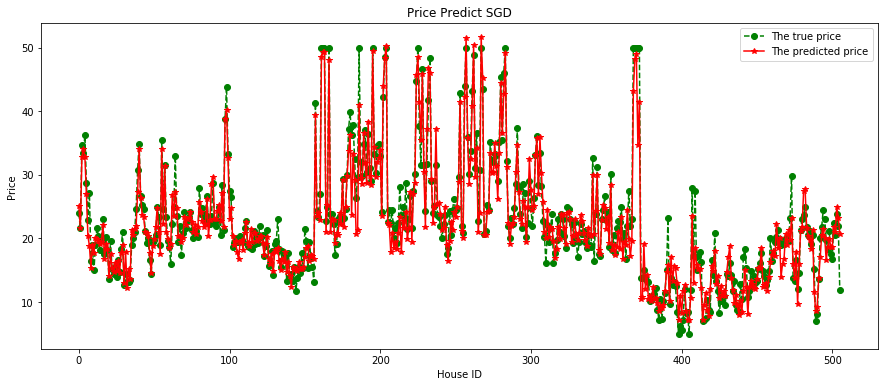

In [39]:
fig = plt.figure(figsize=(15,6))
plt.plot(y_, linestyle="dashed", marker="o", color="green",label='The true price')
plt.plot(output, color="red", marker="*", label='The predicted price')
plt.xlabel("House ID")
plt.ylabel("Price")
plt.title("Price Predict SGD")
plt.legend()
plt.show()

As expected, the house price prediced with NN performs better than with linear regression. The reason is ofc that NN being able to model nonlinear behavior better than vanilla linear regression.